In [1]:
from nltk.corpus import gutenberg, stopwords
from nltk.stem import PorterStemmer
from nltk.text import Text
from nltk import word_tokenize
from string import punctuation
import pandas as pd
import numpy as np
import re
import os
from ast import literal_eval

from collections import defaultdict, Counter
from statistics import mode

pd.options.mode.chained_assignment = None

os.chdir(os.path.dirname(os.getcwd()))

stopwords = stopwords.words('english')
punctuation = list(punctuation)
ps = PorterStemmer()

# Getting the tokens:

In [2]:
def get_tokens(text):
    tokens_raw_lower = word_tokenize(text.lower())
    try:
        tokens = []
        for token in tokens_raw_lower:
            if token.isdigit():
                continue
            elif token in punctuation or token in ["'s","’","--"] or token in stopwords:
                continue
            elif "." in token: # Try with and without!
                continue
            
            token = ps.stem(token)
            tokens.append(token)
        return tokens
    except: return []

In [3]:
character_data = pd.read_csv('ProjectA/descriptions.csv', sep=";", usecols=[1, 2, 3, 4, 5], converters={4: literal_eval})

ind_list = np.nonzero([r"(" in i for i in character_data["name"]])[0]
char_list = list([character_data["name"].iloc[i] for i in ind_list])
bool_list = [char.split(" ") for char in list(char_list)]

names = []
nicknames = []
for i in bool_list:
    for idx, el in enumerate(i):
        if r"(" in el:
            names.append(" ".join(i[:idx]))
            nicknames.append([" ".join(i[:idx]), " ".join(i[idx:])[1:-1]])

for i in range(len(ind_list)):
    character_data["name"].iloc[ind_list[i]] = names[i]
    
name_dict = dict(zip(names, nicknames))

def funcer(x):
    try: return name_dict[x]
    except: return [x]

character_data['nicknames'] = character_data["name"].apply(funcer)
character_data["name"].iloc[:4] = ["Rod", "Quasar", "Kane", "Flash Raktor"]
character_data["nicknames"].iloc[:4] = [["Hyper", "Rod"], ["Quick-Draw", "Quasar"], ["Steel Claw", "Kane"], ["The Trickster", "Flash Raktor"]]
character_data.set_index("name", inplace=True)
character_data = character_data.sort_index()
# ^^^ Above is just a way too complicated way to fix the dataset.

# Defining a general star wars word dictionary:
star_wars_vocab = word_tokenize(" ".join(character_data["description"]).lower())
star_wars_vocab_dict = defaultdict(list)
for v in star_wars_vocab: # This creates a dictionary of connections between stemmed words and the originals.
    star_wars_vocab_dict[ps.stem(v)].append(v)

# We can get the tokens, but unfortunately they are stemmed which is only relevant for getting the frequency of unique words.
# And we still want to be able to display some beautiful word clouds with actual words that match (as best as possible) the original words.
# So we choose the most frequent and therefore most likely original version of the stemmed word, and replace it with that universally:
token_beautifier = lambda token: mode(sorted(star_wars_vocab_dict[token]))

# Creating the tokens column:
character_data["tokens"] = character_data["description"].apply(get_tokens).apply(lambda tokens: list(map(token_beautifier, tokens)))
# Rearranging columns:
character_data = character_data[["nicknames", "description", "tokens", "properties", "referrals", "history"]]
character_data

,nicknames,description,tokens,properties,referrals,history
name,,,,,,
2BR-NTB,[2BR-NTB],"Loyal to Norath Kev, the droid 2BR-NTB has a d...","[loyal, norath, kev, droid, 2br-ntb, distinct,...",{'Appearances': ['Star Wars Resistance']},NaN,NaN
4-LOM,[4-LOM],"A rusty droid with insectile features, 4-LOM w...","[rusty, droid, insectile, features, 4-lom, ori...",{'Appearances': ['Star Wars: The Empire Strike...,NaN,NaN
4D-M1N,[4D-M1N],When Captain Doza needs guests escorted into D...,"[captain, doza, needed, guests, escort, doza, ...",{'Appearances': ['Star Wars Resistance']},NaN,NaN
5-L,[5-L],A mouse droid serving aboard a First Order Sta...,"[mouse, droid, served, aboard, first, order, s...",{'Appearances': ['Star Wars Resistance']},NaN,NaN
8D8,[8D8],"A lanky smelter droid, during the time of the ...","[lanky, smelter, droid, time, empire, 8d8, ass...",{'Appearances': ['Star Wars: Return of the Jed...,NaN,NaN
...,...,...,...,...,...,...
Ziton Moj,[Ziton Moj],His gruff demeanor and devilish grin indicated...,"[gruff, demeanor, devilish, grin, indicate, zi...","{'Appearances': ['Star Wars: The Clone Wars'],...",NaN,NaN
Zorii Bliss,[Zorii Bliss],It is difficult for scoundrels to remain neutr...,"[difficult, scoundrels, remain, neutral, wars,...",{'Appearances': ['Star Wars: The Rise of Skywa...,NaN,NaN
Zuckuss,[Zuckuss],"A Gand bounty hunter, Zuckuss heeded the Empir...","[gand, bounty, hunter, zuckuss, heed, empire, ...",{'Appearances': ['Star Wars: The Empire Strike...,NaN,NaN


In [4]:
# Saving the dataset:
character_data.to_csv("ProjectA/descriptions_tokens.csv", sep=";")

# Creating the character groups:

In [11]:
# FORMAT : [ [char1_name, char2_name, ... ], [char93_name, char97_name, ... ], ... ]
# Where all characters are sorted into these sorts of groups with their names.

character_groups = [character_data.iloc[:100], character_data.iloc[100:]]

# Calculating the TF-IDF for each group:

In [20]:
# TF and IDF formulas:
IDF = lambda term_count: np.log10(len(character_data) / term_count)
TF = lambda term_count, N: (term_count / N) * 100

corpus_total_tokens = sum(character_data["tokens"].apply(set).apply(list), [])
corpus_total_tokens_count = Counter(corpus_total_tokens)
IDF_dict = {word: IDF(count) for word, count in corpus_total_tokens_count.items()}

community_TF_IDF = []
for character_group in character_groups:
    group_total_tokens = sum(character_group["tokens"], [])
    group_total_tokens_count = Counter(group_total_tokens)
    
    tf_idf = {word: TF(count, len(group_total_tokens)) * IDF_dict[word] for word, count in group_total_tokens_count.items()}
    community_TF_IDF.append(dict(sorted(tf_idf.items(), key=lambda item: item[1], reverse=True)))
    
community_TF_IDF

[{'droid': 0.7763356673899677,
  'jedi': 0.6539318210061034,
  'admiral': 0.5755512315120073,
  'imperial': 0.4984885931484213,
  'resistance': 0.4968647036083247,
  'empire': 0.47625668476102,
  'officer': 0.468895029999583,
  'skywalker': 0.4420369727056303,
  'order': 0.4399277092552002,
  'star': 0.438779830311787,
  'commander': 0.4368818916814325,
  'served': 0.4353283265281371,
  'take': 0.42638675212996685,
  'would': 0.42506812117861814,
  'hunter': 0.4167748753602869,
  'ship': 0.40961084971486506,
  'fight': 0.40961084971486506,
  'battle': 0.40931075388549304,
  'rebel': 0.395326114968474,
  'many': 0.3922500160921927,
  'clone': 0.3890967831979383,
  'bounty': 0.3876550837797091,
  'part': 0.38541203665307155,
  'first': 0.38054949395809984,
  'jabba': 0.3736186827170346,
  'destroyed': 0.3711714180597551,
  'death': 0.3661468343993353,
  'one': 0.36545247238554796,
  'vader': 0.35411591649323887,
  'anakin': 0.3528749464471251,
  'assist': 0.35007472366590614,
  'mandalor

# Making wordclouds:

In [ ]:
def combine_dictionaries(dictionaries):
    combined_dict = {}
    counts = {}
    
    for dictionary in dictionaries:
        for key, value in dictionary.items():
            if key not in combined_dict:
                combined_dict[key] = value
                counts[key] = 1
            else:
                combined_dict[key] += value
                counts[key] += 1
    
    for key in combined_dict:
        combined_dict[key] /= counts[key]
    
    return dict(sorted(combined_dict.items(), key=lambda item: item[1], reverse=True))

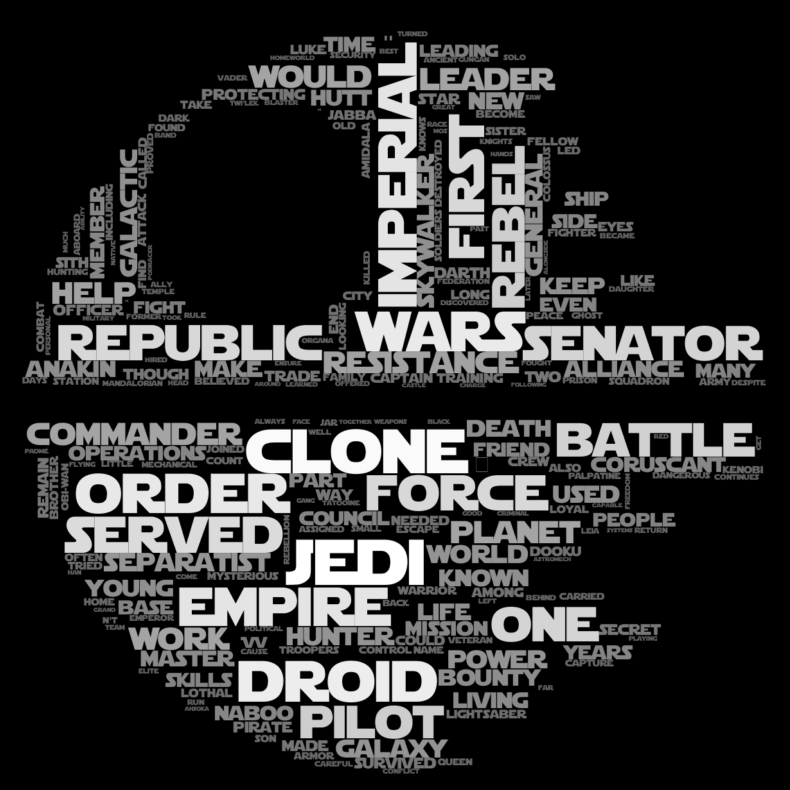

In [224]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from PIL import Image

# sw_mask = np.array(Image.open("ProjectA/images/Rebellion_logo.png").convert('RGB'))
# sw_mask = np.array(Image.open("ProjectA/images/Galactic_Empire_logo.png").convert('RGB'))
sw_mask = np.array(Image.open("ProjectA/images/death_star1.png").convert('RGB'))

def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # return f"hsl(0, 0%, {random.randint(60, 100)}%)"
    return f"hsl(0, 0%, {font_size * 0.7 + 30}%)"

wordcloud = WordCloud(
    font_path="ProjectA/images/StarJedi.ttf", background_color="black",
    width=600, height=600, max_words=400, min_font_size=9, max_font_size=100,
    mask=sw_mask).generate_from_frequencies(combine_dictionaries(community_TF_IDF))

wordcloud = wordcloud.recolor(color_func=grey_color_func, random_state=3)

plt.figure( figsize=(20,10), facecolor='k' );
plt.imshow(wordcloud, interpolation='bilinear');
plt.axis("off");